In [ ]:
!pip install rasterio
!pip install richdem
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from pathlib import Path
import shutil
import pandas as pd  
import richdem as rd

In [ ]:
# Root Directory
Image_Segmentation_Path = '/content/drive/My Drive/Image Segmentation/'

# Inputs/Sources
dirs_pairs = Image_Segmentation_Path + "dirs_pairs.csv"
train_dirs_path = Image_Segmentation_Path + 'train_dirs.csv'
validate_dirs_path = Image_Segmentation_Path + 'validate_dirs.csv'
test_dirs_path = Image_Segmentation_Path + 'test_dris.csv'
# Outputs/Destinations


In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [ ]:
class Dataset(BaseDataset):
  """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.  
  Args:
      images_dir (str): path to images folder
      masks_dir (str): path to segmentation masks folder
      class_values (list): values of classes to extract from segmentation mask
  """
    
  CLASSES = ['non-mound', 'mound', 'invalid data']
    
  def __init__(
          self, 
          dirs,
          classes=None,
          augmentation=None, 
          preprocessing=None,):
    self.df = pd.read_csv(dirs)
    self.ids = self.df['Index'].values.tolist()
    
    # convert str names to class values on masks
    self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
      
      
    self.augmentation = augmentation
    self.preprocessing = preprocessing
    
  def __getitem__(self, i):
    # read data
    with rasterio.open(self.df.at[i, 'Input']) as dem:
      dem_array = dem.read(1)
      
    with rasterio.open(self.df.at[i, 'Target']) as mask:
      mask_array = mask.read(1)
    
    # extract certain classes from mask (e.g. cars)
    masks = [(mask_array == v) for v in self.class_values]
    mask_array = np.stack(masks, axis=-1).astype('float')
    #Expanding arrays to match Pytorch input size
    # dem_array = np.expand_dims(dem_array,axis=(0))
    # mask_array = np.expand_dims(mask_array,axis=(0))

    # apply augmentations
    if self.augmentation:
      sample = self.augmentation(image=dem_array, mask=mask_array)
      dem_array, mask_array = sample['image'], sample['mask']

    # apply preprocessing
    if self.preprocessing:
      sample = self.preprocessing(image=dem_array, mask=mask_array)
      dem_array, mask_array = sample['image'], sample['mask']

    return dem_array, mask_array
      
  def __len__(self):
    return len(self.ids)

In [ ]:
# helper function for data visualization
def visualize(**images):
  """PLot DEM and its mask."""
  for i, (name, image) in enumerate(images.items()):
    dem_rda = rd.rdarray(image, no_data=-32767)
    rd.rdShow(dem_rda, axes=False, cmap='viridis')

In [ ]:
# helper function for data visualization
def visualize_array(dem_array, mask_array):
  """PLot DEM and its mask."""
  dem_rda = rd.rdarray(dem_array, no_data=-32767)
  mask_rda = rd.rdarray(mask_array, no_data=-32767)
  rd.rdShow(dem_rda, axes=False, cmap='viridis')
  rd.rdShow(mask_rda, axes=False)

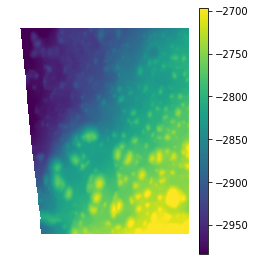

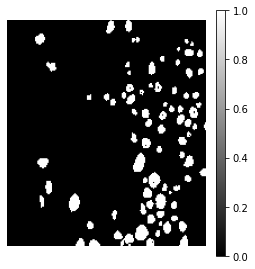

In [ ]:
dataset = Dataset(dirs_pairs, classes=['mound'])
dem_array, mask_array = dataset[1] # get some sample

visualize_array(
    dem_array=dem_array, 
    mask_array=mask_array.transpose(2, 0, 1)[0])

In [ ]:
# !pip install -U git+https://github.com/albu/albumentations --no-cache-dir

In [ ]:
# !pip install --force-reinstall albumentations==1.0.3

In [ ]:
# !pip install --upgrade albumentations

In [ ]:
!pip install git+https://github.com/albumentations-team/albumentations

In [ ]:
import albumentations as albu

In [ ]:
def get_training_augmentation():
  train_transform = [albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0)]

  return albu.Compose(train_transform)


In [ ]:
def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)

In [ ]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

In [ ]:
def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [ ]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [ ]:
# ENCODER = 'se_resnext50_32x4d'
# ENCODER_WEIGHTS = 'imagenet'
# ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multiclass segmentation
# CLASSES = [-1, 0, 1]
# # create segmentation model with pretrained encoder
# model = smp.FPN(
#     encoder_name=ENCODER, 
#     encoder_weights=ENCODER_WEIGHTS, 
#     classes=len(CLASSES), 
#     activation=ACTIVATION,
# )

# preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
CLASSES = ['non-mound', 'mound', 'invalid data']
model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    classes=len(CLASSES),
    in_channels=1,
    activation='softmax2d'                  # model output channels (number of classes in your dataset)
)

preprocessing_fn = smp.encoders.get_preprocessing_fn("resnet34", "imagenet")

In [ ]:
train_dataset = Dataset(train_dirs_path,
                        augmentation=get_training_augmentation(), 
                        preprocessing=get_preprocessing(preprocessing_fn),
                        classes=CLASSES)

valid_dataset = Dataset(validate_dirs_path,
                        augmentation=get_validation_augmentation(), 
                        preprocessing=get_preprocessing(preprocessing_fn),
                        classes=CLASSES)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=1)

In [ ]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    verbose=True,
)

In [ ]:
print(preprocessing_fn)

functools.partial(<function preprocess_input at 0x7f5792ae1cb0>, input_space='RGB', input_range=[0, 1], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


In [ ]:
# train model for 40 epochs

max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/777 [00:00<?, ?it/s]


ValueError: ignored

In [ ]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [ ]:
# create test dataset
test_dataset = Dataset(test_dirs_path,
                       augmentation=get_validation_augmentation(), 
                       preprocessing=get_preprocessing(preprocessing_fn),
                       classes=CLASSES)

test_dataloader = DataLoader(test_dataset)

In [ ]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics)

logs = test_epoch.run(test_dataloader)

In [ ]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    
    x_tensor = torch.from_numpy(image).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )